# Self-Driving Car Project - Track 1 - Lake Track

## 1. Importing Data and Packages
Google Colab is being used to process the code using its free GPUs. To make this possible, the first step is to upload all the data to Google Drive. I recommend uploading directly from GitHub to Google Drive, just as I did (it is better than uploading from your computer to Google Drive as it usually crashes when doing it).

In [ ]:
# This code makes possible to interface with files stored at Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clones my github repository into Google Drive where the images and
# telemetry data (steering angle, throttle, reverse, speed) are stored
!git clone https://github.com/nicholas-necyk/self-driving-car-project.git '/content/drive/My Drive/Colab Notebooks/self-driving-car-project'

In [ ]:
# Importing packages that will be used for this project
import cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [ ]:
# Reading driving_log.csv file (that has the driving log for track1) as a pandas dataframe 
track1_data_path = '/content/drive/My Drive/Colab Notebooks/self-driving-car-project/track1/driving_log.csv'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df = pd.read_csv(track1_data_path, names = columns)

# Displaying the first five rows
df.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_10_17_20_17_02_162.jpg,left_2020_10_17_20_17_02_162.jpg,right_2020_10_17_20_17_02_162.jpg,0.0,0.000000,0,2.937039
1,center_2020_10_17_20_17_02_248.jpg,left_2020_10_17_20_17_02_248.jpg,right_2020_10_17_20_17_02_248.jpg,0.0,0.000000,0,2.913422
2,center_2020_10_17_20_17_02_346.jpg,left_2020_10_17_20_17_02_346.jpg,right_2020_10_17_20_17_02_346.jpg,0.0,0.000000,0,2.884199
3,center_2020_10_17_20_17_02_441.jpg,left_2020_10_17_20_17_02_441.jpg,right_2020_10_17_20_17_02_441.jpg,0.0,0.284236,0,3.190834
4,center_2020_10_17_20_17_02_525.jpg,left_2020_10_17_20_17_02_525.jpg,right_2020_10_17_20_17_02_525.jpg,0.0,0.538558,0,3.682748


## 2. Dealing with Data Imbalance

After plotting the histogram of the steering angles it was clear that most data was for the steering angle of 0. That can be a problem because it can bias the model and make the car drive straight more frequently. So, to deal with this imbalance in the data, rows with a steering angle of 0 were selected at random and then dropped (deleted). Only 400 of these rows were kept on the dataframe (I've tested keeping 200, 250, 300 but 400 gave the best results on the simulator).

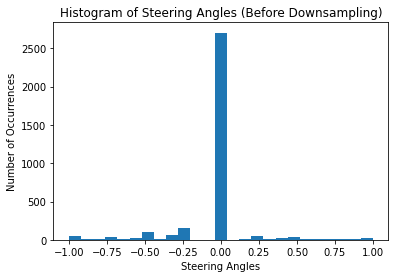

In [ ]:
# Plots the histogram of the steering angles before downsampling
plt.figure()
plt.hist(df['steering'], bins=25)
plt.title('Histogram of Steering Angles (Before Downsampling)')
plt.xlabel('Steering Angles')
plt.ylabel('Number of Occurrences')
plt.show()

In [ ]:
# Top 5 most common steering angles (first column) and number of occurrences (second column)
df['steering'].value_counts().head(5)

 0.00    2704
-0.25     120
-0.50      67
-0.30      57
-1.00      40
Name: steering, dtype: int64

Total number of rows before: 3365
Total number of rows after: 1061


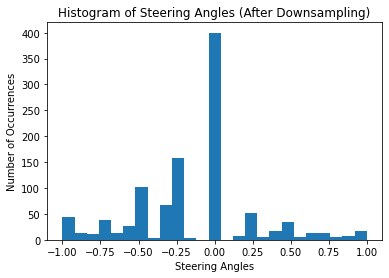

In [ ]:
# Randomly dropping some rows that have steering angle = 0 (downsampling)
num_rows_to_keep = 400 
print(f'Total number of rows before: {df.shape[0]}')
df.drop((df[df['steering']==0]).sample(((df['steering']==0).sum() - num_rows_to_keep), random_state=1).index, inplace=True)
print(f'Total number of rows after: {df.shape[0]}')

# Plots the histogram of the steering angles after downsampling
plt.figure()
plt.hist(df['steering'], bins=25)
plt.title('Histogram of Steering Angles (After Downsampling)')
plt.xlabel('Steering Angles')
plt.ylabel('Number of Occurrences')
plt.show()

## 3. Loading Images
After loading the dataframe with the image names and telemetry data (steering angle, throttle, reverse, speed), now it's time to load the images to a numpy array. One important thing to note is that images from the left and right will have the steering angle corrected. Then, the data will be split between a train set and a validation set.

In [ ]:
def load_images_and_steerings(df):
  '''From a dataframe it gets the image paths and the steering angles returning this information on
  two separate numpy arrays'''

  image_paths = []
  steerings = []
  track1_img_path = '/content/drive/My Drive/Colab Notebooks/self-driving-car-project/track1/IMG/'
  
  for i in range(df.shape[0]):
    center, left, right = df.iloc[i, :3]
    # Appends the left image path and the corrected steering angle
    image_paths.append(str(track1_img_path) + str(left))
    steerings.append(float(df.iloc[i, 3]) + 0.15)
    # Appends the center image path and the steering angle
    image_paths.append(str(track1_img_path) + str(center))
    steerings.append(float(df.iloc[i, 3]))
    # Appends the right image path and the corrected steering angle
    image_paths.append(str(track1_img_path) + str(right))
    steerings.append(float(df.iloc[i, 3]) - 0.15)
  
  image_paths = np.asarray(image_paths)
  steerings = np.asarray(steerings)
  
  return image_paths, steerings

In [ ]:
# Assigns the target and feautures to X and y by using the function defined above
X, y = load_images_and_steerings(df)

# Splits the train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Outputs the number of rows on each set and the total
print(f'Total samples: {X.shape[0]}\nTraining samples: {X_train.shape[0]}\nValidation samples: {X_valid.shape[0]}')

Total samples: 3183
Training samples: 2546
Validation samples: 637


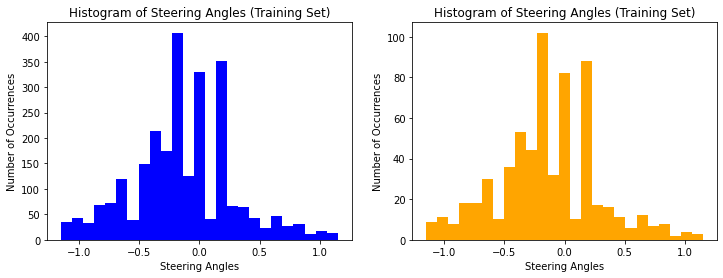

In [ ]:
# Plots the histogram of the steering angles for the training and validation sets 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(y_train, bins=25, color='blue')
axes[0].set_title('Histogram of Steering Angles (Training Set)')
axes[0].set_xlabel('Steering Angles')
axes[0].set_ylabel('Number of Occurrences')

axes[1].hist(y_valid, bins=25, color='orange')
axes[1].set_title('Histogram of Steering Angles (Validation Set)')
axes[1].set_xlabel('Steering Angles')
axes[1].set_ylabel('Number of Occurrences')

plt.show()

## 4. Image Preprocessing

The image was preprocessed by cropping it to remove unnecessary features like the hood of the car and the skies. After that, the image was resized for interfacing better with the model architecture from NVIDIA's paper (that expects the shape of the image to be (66, 200, 3)). Then the image was converted from RGB to YUV and the values were normalized (as done on NVIDIA's paper). Finally, after checking results, the preprocessing function is applied to all the images (and results are checked again).

In [ ]:
def preprocess(image):
  '''Takes the path of the image and returns the preprocessed result'''
  img = plt.imread(image)
  
  # Crop image to remove unnecessary features (front part of the car, skies, etc)
  img = img[60:-25, :, :]

  # Decrease size for easier processing and for interfacing with the model architecture from NVIDIA's paper 
  img = cv2.resize(img, (200, 66), interpolation=cv2.INTER_AREA)
  
  # Convert from RGB to YUV
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  
  # Normalize values (values will be between 0-1)
  img = img / 255

  return img

<Figure size 432x288 with 0 Axes>

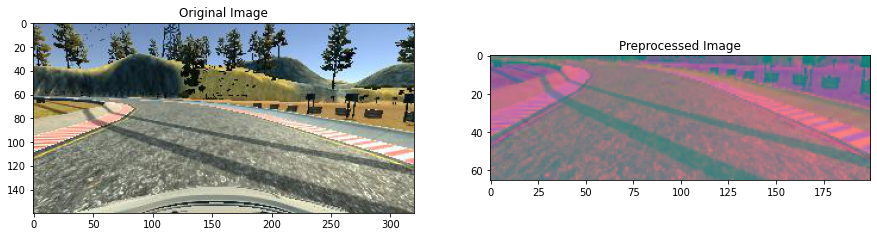

In [ ]:
# Choose any image from the X array
image = X[100]
original_img = plt.imread(image)
preprocessed_img = preprocess(image)

# Plots the original and the preprocessed images to verify the before and after
plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_img)
axes[1].set_title('Preprocessed Image')
plt.show()

In [ ]:
# Apply preprocessing on images from the training and validation sets
X_train = np.array(list(map(preprocess, X_train)))
X_valid = np.array(list(map(preprocess, X_valid)))

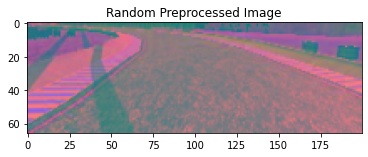

The shape of the training set is: (2546, 66, 200, 3)
The shape of the validation set is: (637, 66, 200, 3)


In [ ]:
# Checking a random preprocessed image
plt.figure()
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.title('Random Preprocessed Image')
plt.show()

# Checking the shape of the training and validation set after all images were preprocessed
print(f'The shape of the training set is: {X_train.shape}\nThe shape of the validation set is: {X_valid.shape}')

## 5. Defining, Fitting and Evaluating the Convolutional Neural Network

The model is defined below based on the model architecture of the paper NVIDIA published about its self-driving car. Some dropout layers are added to the model to reduce overfitting and that paid off well, giving better results on the simulator (the car got less frequently off the track).

This model gets the images and outputs the steering angle (regression model). It has elu as the activation function because elu doesn't let a node die like relu (nodes die when it feeds a value of zero to nodes that follow).

After all those steps we evaluate the loss on the train set and the validation set. It seems that both losses converge well after about 15 epochs, but I'll be using the model's weights after 20 epochs (it's just a choice I made).

In [ ]:
# Defining the model architecture (this is the model based on NVIDIA's self-driving car paper)
model = Sequential()
model.add(Conv2D(24, kernel_size=(5, 5), activation='elu', strides=(2, 2), input_shape = (66, 200, 3)))
model.add(Conv2D(36, kernel_size=(5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(48, kernel_size=(5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(1))

# Print out a summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [ ]:
# Defining the loss metric, the score metric and the network optimizer
model.compile(loss = 'mean_squared_error',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [ ]:
# Fit the model
history = model.fit(X_train, y_train,
                    batch_size = 128,
                    epochs = 20,
                    verbose = 1,
                    validation_data = (X_valid, y_valid))

Epoch 1/20
20/20 [==============================] - 17s 835ms/step - loss: 0.4723 - accuracy: 0.1174 - val_loss: 0.1579 - val_accuracy: 0.1287
Epoch 2/20
20/20 [==============================] - 16s 819ms/step - loss: 0.1996 - accuracy: 0.1284 - val_loss: 0.1414 - val_accuracy: 0.1287
Epoch 3/20
20/20 [==============================] - 16s 820ms/step - loss: 0.1801 - accuracy: 0.1288 - val_loss: 0.1280 - val_accuracy: 0.1287
Epoch 4/20
20/20 [==============================] - 16s 825ms/step - loss: 0.1646 - accuracy: 0.1288 - val_loss: 0.1204 - val_accuracy: 0.1287
Epoch 5/20
20/20 [==============================] - 20s 985ms/step - loss: 0.1540 - accuracy: 0.1284 - val_loss: 0.1113 - val_accuracy: 0.1287
Epoch 6/20
20/20 [==============================] - 17s 826ms/step - loss: 0.1482 - accuracy: 0.1300 - val_loss: 0.1117 - val_accuracy: 0.1287
Epoch 7/20
20/20 [==============================] - 16s 824ms/step - loss: 0.1430 - accuracy: 0.1280 - val_loss: 0.1089 - val_accuracy: 0.1287

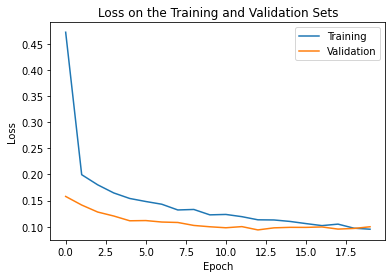

In [ ]:
# Plot the train and validation loss on each epoch 
plt.figure()
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.title('Loss on the Training and Validation Sets')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## 6. Saving the model

The model needs to be saved to a .h5 file to be used afterwards for predicting the steering angles on the simulator.

In [ ]:
# Save the model (for future use: to predict the steering angles on the simulator)
model.save('model.h5')

In [ ]:
# Download the model.h5 file from Google Colab
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>